In [1]:
from genetic.mutate import mutate
from genetic.crossover import crossover
from genetic.random_sample import generate_random_samples

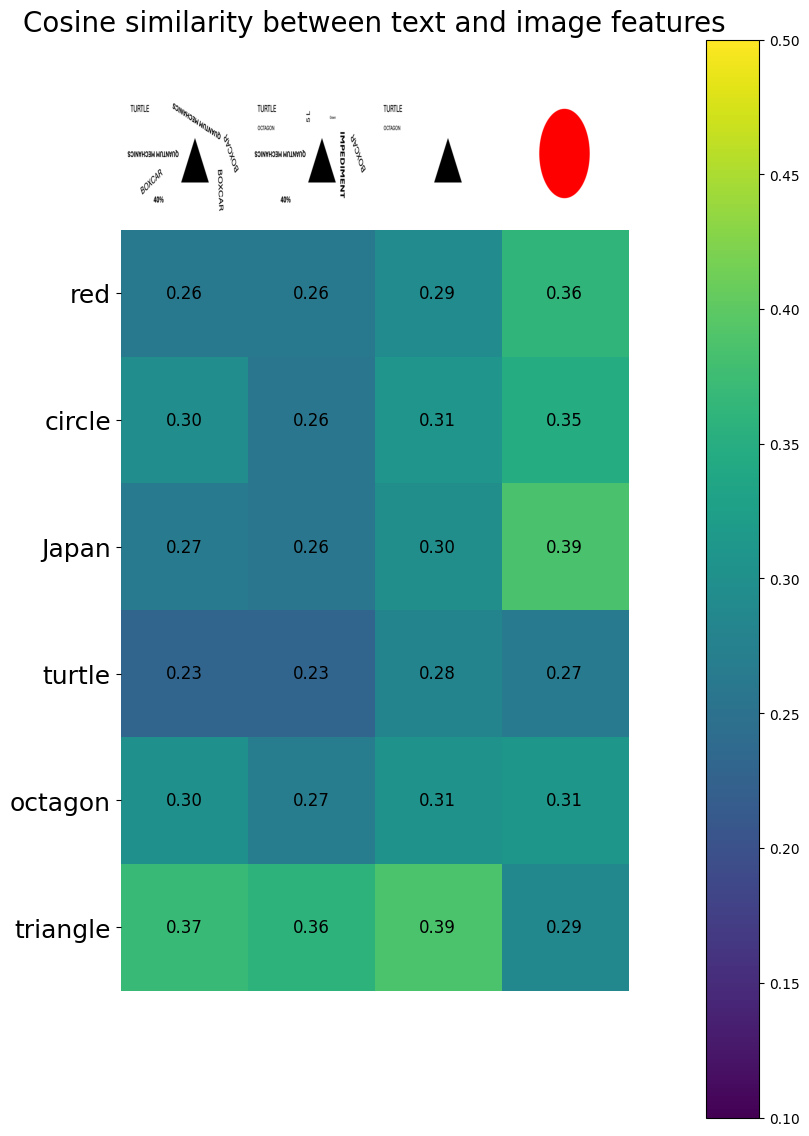

In [42]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from visual.clip_utils import similarities_heat_map

OCR_TESTING = True

if OCR_TESTING:
    image_root = os.path.join('images', 'OCR testing')
else:
    image_root = 'images'

image_paths = [os.path.join(image_root, _) for _ in os.listdir(image_root) if _.endswith('.png')]
images_dict = {_: Image.open(_).convert("RGB") for _ in image_paths}

images = []
texts = []

for fname, image in images_dict.items():
    images.append(image)
    if not OCR_TESTING:
        texts.append(os.path.split(fname)[1].split('.')[0])

if OCR_TESTING:
    texts += \
        ['red', 'circle', 'Japan'] + \
        ['turtle', 'octagon', 'triangle']  # + \
        # ['quantum mechanics', '40%', 'percentage']  # + \
        # ['quantum mechanics', 'gown', '40%', 'percentage', '30%', '5 L', 'liters'] + \
similarities_heat_map(texts, images)
plt.show()

In [3]:
# images[2]

In [4]:
from visual.clip_utils import texts_images_similarities

DEFAULT_OBJECTIVE_IMAGE = images[2]


def fitness_function(*texts, objective_image=DEFAULT_OBJECTIVE_IMAGE):
    return texts_images_similarities(texts, [objective_image])

In [5]:
# texts = [
#     'pie chart',
#     'circle', 
#     'Fusarium',
#     'Lactobacillus',
#     'Pythium',
#     'blue',
#     'cyan',
# ]

# fitnesses = fitness_function(*texts)
# fitnesses

In [6]:
import json
import uuid


def _generate_text():
    text = []
    while len(text) < 1:
        text += generate_random_samples()
    return text[0]


class Individual:

    def __init__(self, text=None, generation=0, id=None, fitness=None):
        self.text = text or _generate_text()
        self.generation = generation
        self.id = id or uuid.uuid4().hex
        self.fitness = fitness
    
    def __repr__(self) -> str:
        fitness_str = f' ({self.fitness:.04f})' if not self.fitness is None else ''
        return f'Gen {self.generation}{fitness_str}: "{self.text}"'
    
    def __str__(self) -> str:
        return repr(self)
    
    def save(self, filename):
        with open(filename, 'w') as f:
            obj = {
                'text': self.text,
                'generation': self.generation,
                'id': self.id,
                'fitness': float(self.fitness) if self.fitness is not None else -1
            }
            json.dump(obj, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as f:
            obj = json.load(f)
            fitness = obj['fitness']
            fitness = None if fitness == -1 else fitness
            return cls(
                text=obj['text'],
                generation=obj['generation'],
                id=obj['id'],
                fitness=fitness
            )



In [7]:
def evaluate(population):
    fitnesses = fitness_function(*[_.text for _ in population]).reshape(len(population))
    for p, f in zip(population, fitnesses):
        p.fitness = f
    return fitnesses

In [8]:
# fitnesses = evaluate(initial_population)
# initial_population

In [17]:
def sort_pop(population):
    return sorted(population, key=lambda x: x.fitness, reverse=True)
    # return population

# sort_pop(initial_population)

In [10]:
from roulette_selector import roulette

def select_from_population(population, n_select=1, weighting_func=None):
    assert all(_.fitness is not None for _ in population), 'population must be evaluated before being selected from'
    if weighting_func:
        options = {individual: weighting_func(individual.fitness, population) for individual in population}
    else:
        options = {individual: individual.fitness for individual in population}

    selected = []
    while len(selected) < n_select:
        selected_individual = roulette(options)
        selected.append(selected_individual)
        options.pop(selected_individual)
    return selected, list(options.keys())

In [11]:
def mutate_individual(mutant_candidate, max_offspring=1):
    mutated_texts = mutate(mutant_candidate.text)
    random.shuffle(mutated_texts)
    return [Individual(mutated_texts[i], mutant_candidate.generation + 1) for i in range(max(len(mutated_texts), max_offspring))]

In [12]:
def crossover_individuals(mother_candidate, father_candidate, max_offspring=2):
    crossover_texts = crossover(mother_candidate.text, father_candidate.text)
    random.shuffle(crossover_texts)
    return [Individual(crossover_texts[i], max(mother_candidate.generation, father_candidate.generation) + 1) for i in range(max(len(crossover_texts), max_offspring))]

In [25]:
def mean_fitness(population):
    return sum(_.fitness for _ in population) / len(population)

In [1]:
from tqdm import tqdm
import os


n_population = 20
new_mutants_per_generation = 6
new_crossovers_per_generation = 9
new_offspring_per_crossover = 2
n_generations = 20
keep_top_k = 5


# initial_population = [Individual() for _ in tqdm(range(population_size))]
population = [Individual.load(os.path.join('population', _)) for _ in os.listdir('population')]
evaluate(population)
# initial_population

for generation in tqdm(range(n_generations)):
    print(f'starting generation {generation+1}')
    
    new_mutants = []
    print('creating new mutants')
    # while len(new_mutants) < new_mutants_per_generation:
    #     candidate = select_from_population(population)[0][0]
    #     new_mutants += mutate_individual(candidate)
    for _ in tqdm(range(new_mutants_per_generation)):
        candidate = select_from_population(population)[0][0]
        new_mutants += mutate_individual(candidate)
    
    new_mutants = new_mutants[:new_mutants_per_generation]
    print(f'{len(new_mutants)} mutants created')

    print('creating new crossovers')
    new_crossovers = []
    # while len(new_crossovers) < new_crossovers_per_generation:
    #     mother, father = select_from_population(population, 2)[0]
    #     new_crossovers += crossover_individuals(mother, father)

    for _ in tqdm(range(0, new_crossovers_per_generation+1, new_offspring_per_crossover)):
        children = []
        while len(children) < new_offspring_per_crossover:
            mother, father = select_from_population(population, 2)[0]
            children += crossover_individuals(mother, father)
        new_crossovers += children[:new_offspring_per_crossover]
    
    new_crossovers = new_crossovers[:new_crossovers_per_generation]
    print(f'{len(new_crossovers)} crossovers created')

    print(f'average fitness of previous population {mean_fitness(population)}')
    new_population = new_mutants + new_crossovers
    
    evaluate(new_population)
    print(f'average fitness of new individuals {mean_fitness(new_population)}')
    
    combined_population = sort_pop(new_population + population)
    retained_population = []
    retained_population += combined_population[:keep_top_k]
    retained_population += select_from_population(combined_population, n_select = n_population - keep_top_k)[0]
    assert len(retained_population) == n_population
    print(f'average fitness of retained individuals {mean_fitness(retained_population)}')

    population = retained_population


NameError: name 'os' is not defined

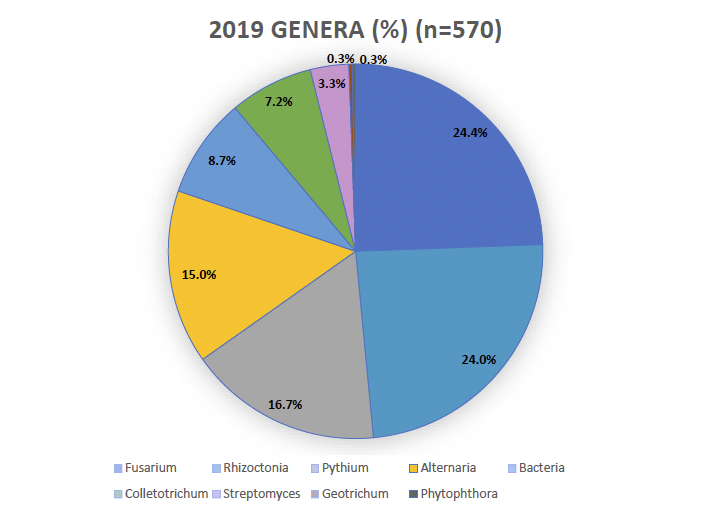

In [39]:
DEFAULT_OBJECTIVE_IMAGE

In [38]:
retained_population

[Gen 6 (0.2764): "outperforming predictions.",
 Gen 6 (0.2764): "outperforming predictions.",
 Gen 7 (0.2608): "Outperforming predictions,",
 Gen 3 (0.2545): "The experimental aircraft exceeded expectations by reaching new heights"",
 Gen 3 (0.2545): "The experimental aircraft exceeded expectations by reaching new heights"",
 Gen 2 (0.2480): "The research plane surpassed projections by soaring to impressive altitudes"",
 Gen 1 (0.2543): "The experimental aircraft exceeded expectations by reaching great heights"",
 Gen 4 (0.2397): "The experimental aircraft exceeded expectations by soaring to new heights.",
 Gen 5 (0.1981): "My hand was nuzzled by an extraordinary height-",
 Gen 5 (0.1695): "The house was dwarfed by the towering tree and experimental aircraft.",
 Gen 8 (0.1541): "The cat purred while I was driving.",
 Gen 7 (0.2608): "Outperforming predictions,",
 Gen 5 (0.1595): "The cat purred contentedly as it rubbed against my hand"",
 Gen 6 (0.1380): "The cat's whiskers were blown 

In [ ]:
# selected, unselected = select_from_population(initial_population, n_select=3)
# print(sum(_.fitness for _ in selected) / len(selected))
# print(sum(_.fitness for _ in unselected) / len(unselected))
# selected

In [ ]:
# mutant_candidate = selected.pop(0)
# mutated_text = mutate(mutant_candidate.text)
# print(mutant_candidate.text)
# print(mutated_text)

In [ ]:
# mother_candidate, father_candidate = selected
# crossover_text = crossover(mother_candidate.text, father_candidate.text)
# print(mother_candidate.text)
# print(father_candidate.text)
# print(crossover_text)